**Research Topics in Computer Vision :: Evaluating the TensorMask** 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import torch, torchvision
assert torch.__version__.startswith("1.8")   
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html


In [6]:
!pip install pyyaml==5.1
!gcc --version

     |████████████████████████████████| 276kB 11.3MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=08094a22e99bf316cf982967f8bc082a10d56e99a1eebd6e1019d8a38a562667
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 5.4.1
    Uninstalling PyYAML-5.4.1:
      Successfully uninstalled PyYAML-5.4.1


gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [1]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo
!pip install -e /content/detectron2_repo/projects/TensorMask

fatal: destination path 'detectron2_repo' already exists and is not an empty directory.
Obtaining file:///content/detectron2_repo
  Found existing installation: detectron2 0.4
    Can't uninstall 'detectron2'. No files were found to uninstall.
  Running setup.py develop for detectron2
Obtaining file:///content/detectron2_repo/projects/TensorMask
  Running setup.py develop for tensormask


In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [3]:
import matplotlib.pyplot as plt
import os, json, cv2, random
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

In [4]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2_repo.projects import TensorMask
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.data.datasets import register_coco_instances

In [5]:
%cd /content/detectron2_repo/projects/TensorMask
from tensormask import add_tensormask_config

/content/detectron2_repo/projects/TensorMask


In [23]:
cfg = get_cfg()
add_tensormask_config(cfg)
cfg.merge_from_file("/content/detectron2_repo/projects/TensorMask/configs/tensormask_R_50_FPN_6x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/model_final_e8df31.pkl"
predictor = DefaultPredictor(cfg)

The checkpoint state_dict contains keys that are not used by the model:
  anchor_generator.cell_anchors.{0, 1, 2, 3, 4, 5}


***Registering the Coco Validation 2017 Set***

In [ ]:
register_coco_instances("coco_val", {}, "/content/drive/MyDrive/instances_val2017.json", "/content/drive/MyDrive/val2017")
dataset_dicts = DatasetCatalog.get("coco_val")
cocoval_metadata = MetadataCatalog.get("coco_val")

***Registering the Tiny Voc Training Set***

In [25]:
register_coco_instances("tiny_voc_train", {}, "/content/drive/MyDrive/tiny_voc_coco_train.json", "/content/drive/MyDrive/voc_train_images")
dataset_dicts = DatasetCatalog.get("tiny_voc_train")
cocoval_metadata = MetadataCatalog.get("tiny_voc_train")

[05/23 15:37:30 d2.data.datasets.coco]: Loading /content/drive/MyDrive/tiny_voc_coco_train.json takes 1.54 seconds.
WARNING [05/23 15:37:30 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/23 15:37:30 d2.data.datasets.coco]: Loaded 1349 images in COCO format from /content/drive/MyDrive/tiny_voc_coco_train.json


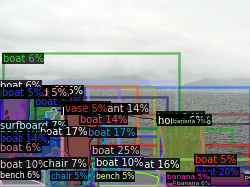

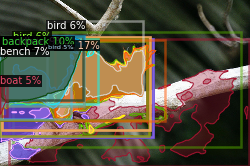

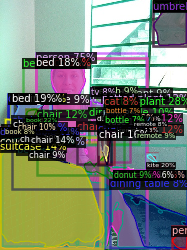

In [28]:
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=cocoval_metadata,
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

***Performing Evaluation on Coco Validation 2017 Set***

In [19]:
evaluator = COCOEvaluator("coco_val", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "coco_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))


[05/23 13:57:56 d2.data.datasets.coco]: Loaded 5000 images in COCO format from /content/drive/MyDrive/instances_val2017.json
[05/23 13:57:57 d2.data.build]: Distribution of instances among all 80 categories:
|   category    | #instances   |   category   | #instances   |   category    | #instances   |
|:-------------:|:-------------|:------------:|:-------------|:-------------:|:-------------|
|    person     | 10777        |   bicycle    | 314          |      car      | 1918         |
|  motorcycle   | 367          |   airplane   | 143          |      bus      | 283          |
|     train     | 190          |    truck     | 414          |     boat      | 424          |
| traffic light | 634          | fire hydrant | 101          |   stop sign   | 75           |
| parking meter | 60           |    bench     | 411          |     bird      | 427          |
|      cat      | 202          |     dog      | 218          |     horse     | 272          |
|     sheep     | 354          |     cow

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[05/23 13:58:10 d2.evaluation.evaluator]: Inference done 11/5000. Dataloading: 0.0013 s / iter. Inference: 0.9830 s / iter. Eval: 0.0700 s / iter. Total: 1.0543 s / iter. ETA=1:27:39
[05/23 13:58:15 d2.evaluation.evaluator]: Inference done 16/5000. Dataloading: 0.0022 s / iter. Inference: 0.9756 s / iter. Eval: 0.0675 s / iter. Total: 1.0456 s / iter. ETA=1:26:51
[05/23 13:58:20 d2.evaluation.evaluator]: Inference done 21/5000. Dataloading: 0.0024 s / iter. Inference: 0.9655 s / iter. Eval: 0.0691 s / iter. Total: 1.0374 s / iter. ETA=1:26:05
[05/23 13:58:26 d2.evaluation.evaluator]: Inference done 26/5000. Dataloading: 0.0025 s / iter. Inference: 0.9788 s / iter. Eval: 0.0732 s / iter. Total: 1.0550 s / iter. ETA=1:27:27
[05/23 13:58:31 d2.evaluation.evaluator]: Inference done 31/5000. Dataloading: 0.0025 s / iter. Inference: 0.9896 s / iter. Eval: 0.0708 s / iter. Total: 1.0633 s / iter. ETA=1:28:03
[05/23 13:58:36 d2.evaluation.evaluator]: Inference done 36/5000. Dataloading: 0.0024

***Performing Evaluation on the Tiny Voc Training Dataset***

In [30]:
evaluator = COCOEvaluator("tiny_voc_train", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "tiny_voc_train")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

WARNING [05/23 15:44:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/23 15:44:31 d2.data.datasets.coco]: Loaded 1349 images in COCO format from /content/drive/MyDrive/tiny_voc_coco_train.json
[05/23 15:44:31 d2.data.build]: Distribution of instances among all 80 categories:
|   category    | #instances   |   category   | #instances   |   category    | #instances   |
|:-------------:|:-------------|:------------:|:-------------|:-------------:|:-------------|
|    person     | 797          |   bicycle    | 99           |      car      | 238          |
|  motorcycle   | 91           |   airplane   | 103          |      bus      | 111          |
|     train     | 87           |    truck     | 0            |     boat      | 99           |
| traffic light | 0            | fire hydrant | 0            |   stop sign   | 0            |
| parking meter | 0            |    bench     | 0            |     bird      | 130      

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[05/23 15:44:44 d2.evaluation.evaluator]: Inference done 11/1349. Dataloading: 0.0013 s / iter. Inference: 0.9728 s / iter. Eval: 0.0320 s / iter. Total: 1.0061 s / iter. ETA=0:22:26
[05/23 15:44:49 d2.evaluation.evaluator]: Inference done 16/1349. Dataloading: 0.0017 s / iter. Inference: 0.9780 s / iter. Eval: 0.0345 s / iter. Total: 1.0148 s / iter. ETA=0:22:32
[05/23 15:44:55 d2.evaluation.evaluator]: Inference done 22/1349. Dataloading: 0.0022 s / iter. Inference: 0.9657 s / iter. Eval: 0.0370 s / iter. Total: 1.0053 s / iter. ETA=0:22:14
[05/23 15:45:01 d2.evaluation.evaluator]: Inference done 28/1349. Dataloading: 0.0023 s / iter. Inference: 0.9566 s / iter. Eval: 0.0389 s / iter. Total: 0.9981 s / iter. ETA=0:21:58
[05/23 15:45:07 d2.evaluation.evaluator]: Inference done 34/1349. Dataloading: 0.0024 s / iter. Inference: 0.9585 s / iter. Eval: 0.0365 s / iter. Total: 0.9978 s / iter. ETA=0:21:52
[05/23 15:45:12 d2.evaluation.evaluator]: Inference done 39/1349. Dataloading: 0.0026